## Home work 6

## About the dataset.  
- The dataset was generated using Monte Carlo simluations of the particle collisions that produce other particles and resulting decay products. The main objective is to separate particle-producing collisions from collisions that did not change background source.  
- There are 28 features and > 1 million instances.  

## Methods  
- It is a classification task with 0 or 1 target response.  
    - 1 = particle resulted from collision.  
    - 0 = only background signal was received after collision.  
- Below is a Tensorflow/Keras implementation of the problem.  
- Please note that this training was done on a GPU with weights saved.
    - Post-processing was done on a different computer. 

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import keras
import numpy as np


## Verify that Tensorflow can see the GPU

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
import os
os.getcwd()

'C:\\Users\\John Olanipekun\\Documents\\Machine Learning\\SMU_Machine_Learning'

## Read in the dataset.  
- We will try if pandas can successfully read in the massive dataset before exploring Dask or PySpark. 

In [11]:
path = "./all_train.csv"
# load the csv file as a dataframe
df = pd.read_csv(path)
# store the inputs and outputs
df.head(n=3)
#Train test split



,# label,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f18,f19,f20,f21,f22,f23,f24,f25,f26,mass
0,1.0,-0.346368,0.416306,0.999236,0.475342,0.427493,-0.005984,1.989833,0.344530,1.566297,...,4.105282,0.267826,0.378718,1.743123,3.406367,4.350537,-0.352571,1.130032,2.227706,1000.0
1,1.0,1.708236,-0.319394,-1.241873,-0.887231,-0.871906,-0.005984,-0.001047,-1.038225,0.655748,...,-1.178141,-0.877361,-1.483769,-0.573682,-1.693781,-0.545062,-0.299118,-0.662942,-0.193019,750.0
2,0.0,-0.360693,1.794174,0.264738,-0.472273,-0.292344,-1.054221,-1.150495,1.423404,1.270098,...,-1.199511,0.539020,-1.590629,-0.573682,-0.543636,-0.937456,-0.300344,-0.523262,-1.506304,750.0


**EDA done on a different machine showed my that most of the features except 'mass' attribute was skewed.** 
- So we will scale the 'mass' attribute.  
- The target response in this data is the 1st column.  
- We will remove the '#' character in the label.  
- I also observed and as was confirmed by the metadata, that the dataset does not suffer from class imbalance with respect to the target variable.  

## Split.  
- We have a big data so we can set aside validation set and test set.  
- so we have 3-way split.  

In [57]:
#train, test = train_test_split(df1, test_size=0.3,random_state=42, stratify = df1['# label'])
scaler = StandardScaler()
#train, test, y_train_, y_test_ = train_test_split(df, df['# label'], test_size=0.30, random_state=200)
train, remain, y_train_, y_remain = train_test_split(df, df['# label'], test_size=0.40, random_state=200)
valid, test, y_valid, y_test_ = train_test_split(remain, remain['# label'], test_size=0.50, random_state=200)
train['mass'] = scaler.fit_transform(train['mass'].values.reshape(-1, 1))
test['mass'] = scaler.transform(test['mass'].values.reshape(-1, 1))  
valid['mass'] = scaler.transform(valid['mass'].values.reshape(-1, 1))  
train = train.drop(['# label'], axis=1)
test = test.drop(['# label'], axis=1)
valid = valid.drop(['# label'], axis=1)


C:\Users\JOHNOL~1\AppData\Local\Temp/ipykernel_2044/3114481359.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['mass'] = scaler.fit_transform(train['mass'].values.reshape(-1, 1))
C:\Users\JOHNOL~1\AppData\Local\Temp/ipykernel_2044/3114481359.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['mass'] = scaler.transform(test['mass'].values.reshape(-1, 1))
C:\Users\JOHNOL~1\AppData\Local\Temp/ipykernel_2044/3114481359.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

# The Model architecture, fit and prediction.  
### Key hyperparameters.  
- Reasonably large epoch size of 100 was chosen but will be checked by early stopping, to prevent overfit.    
- Batch size is set to 2048 which is optimally large and is the favourable multiple of 32 bits.  
- Call backs:
    - I have two callbacks:
        1. save the weights of the model training since I will be transferring the notebook to another computer.
            - So I can use only the weight for prediction if I lose the current variables.
       2. I have **EarlyStopping** criterion to halt training should there be no improvement to metric being monitored.  
       - The stopping criterion is set to monitor validation accuracy.  
       - This is because validation accuracy is better evaluation of the model performance on unseen test data set.  
       - We want to maximize this accuracy so we set the 'mode' parameter to 'max'.  
       - **patience** parameter is set to 10 to give the model room to train.  
           - This indicates that wait at least 10 epochs before stopping the model training.  
           
- We set the learning rate to 0.03 arbitrarily.  
- Adaptive moment estimation (Adam) is chosen as the optimization algorithm.  
- It is quite popular because is one of the algorithms that compute gradient descent fast. 
       


In [59]:
EPOCHS = 100
BATCH_SIZE = 2048

callbacks =[
    keras.callbacks.ModelCheckpoint(
        './weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1), 
    tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)
]

### Model Architecture.  
- We will be training on 3 hidden layers and 1 output layer.  
- The output layer is set to output 1 value (0 or 1) because we are using binary classification.  
- We expect the model to take as input, a minibatch of 2048 instances and 28 attibutes through its input layers and then pass its output to the 1st hidden layer.  
- During this forward pass, the algorithm computes output for each neuron in the layer, which is then passed on to the next layer. 
- At the last layer, it will compute the output error for each training instance, and finds which neuron contributed how much to that error. 
- It will backpropagate these error back all the way to the 1 layer.  
- It then updates the weights of each neuron based on the gradient computed during this revrse process. 

## Loss function.  
- We choose binary_crossentropy because this task is binary classification.  
- Correspondingly we chose the sigmoid activation rather than softmax because we want 0 or 1 value. While softmax is best suited for multiclass outputs.  

In [60]:
tf.random.set_seed(42)


model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(lr=0.03),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

history = model.fit(train.values,
                    y_train_.values,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(valid.values, y_valid.values), callbacks=callbacks
                   )

C:\Users\John Olanipekun\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
2051/2051 [==============================] - 6s 3ms/step - loss: 0.3003 - accuracy: 0.8653 - precision: 0.8460 - recall: 0.8932 - val_loss: 0.2783 - val_accuracy: 0.8740 - val_precision: 0.8606 - val_recall: 0.8929

Epoch 00001: saving model to .\weights.01-0.28.hdf5
Epoch 2/100
2051/2051 [==============================] - 5s 3ms/step - loss: 0.2766 - accuracy: 0.8746 - precision: 0.8566 - recall: 0.8997 - val_loss: 0.2735 - val_accuracy: 0.8762 - val_precision: 0.8614 - val_recall: 0.8969

Epoch 00002: saving model to .\weights.02-0.27.hdf5
Epoch 3/100
2051/2051 [==============================] - 5s 3ms/step - loss: 0.2740 - accuracy: 0.8762 - precision: 0.8593 - recall: 0.8996 - val_loss: 0.2742 - val_accuracy: 0.8771 - val_precision: 0.8658 - val_recall: 0.8926

Epoch 00003: saving model to .\weights.03-0.27.hdf5
Epoch 4/100
2051/2051 [==============================] - 5s 3ms/step - loss: 0.2723 - accuracy: 0.8771 - precision: 0.8609 - recall: 0.8996 - val_loss: 0.2735 -

## Training history.  
- We have 100 epochs.  
- We want to minimize our loss function (binary cross entropy).  
- We want to maximize our accuracy, precision and recall for the validation set.  
    - These start from >80% and are increasing up to 41st epoch when the early stopping criterion condition halted the training because there was no significant improvement to validation accuracy after 10 epochs.  
-  **Validation accuracy = 88%, precision=88%, recall = 88%**.  
- We will see the performance of the model weights on the test set.
  

# Prediction.  
- We predict on the test set with decision threshld set to 0.5. 

In [64]:
predictions = model.predict(test.values)

In [65]:
prediction_classes = [
    1 if prob > 0.5 else 0 for prob in np.ravel(predictions)
]

## Evaluation.  
- The model produced very similar Accuracy, precision and recall values (88%, 86%, 91% respectfully) as we saw with the validation set during training. 
- Therefore, we can see that the model will be accurate in prediction if particle collision will form another particle or just background signal 88 % of the time.  

In [66]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test_, prediction_classes))

[[597304 101952]
 [ 63924 636820]]


In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print(f'Accuracy: {accuracy_score(y_test_, prediction_classes):.2f}')
print(f'Precision: {precision_score(y_test_, prediction_classes):.2f}')
print(f'Recall: {recall_score(y_test_, prediction_classes):.2f}')

Accuracy: 0.88
Precision: 0.86
Recall: 0.91


## Backup the history.  
-We store the training loss, accuracy, precision as history.

In [74]:
loss=history.history['loss']
accuracy=history.history['accuracy']
precision=history.history['precision']
recall= history.history['recall']
hist_dict={}
hist_dict['loss']=loss
hist_dict['accuracy']=accuracy
hist_dict['precision']=precision
hist_dict['recall']=recall


In [75]:
hist_dict

{'loss': [0.3002937138080597,
  0.2766357660293579,
  0.2739705443382263,
  0.272262841463089,
  0.2711673378944397,
  0.2703096270561218,
  0.27799054980278015,
  0.2687784731388092,
  0.26892217993736267,
  0.26824745535850525,
  0.2678259313106537,
  0.26747849583625793,
  0.26744091510772705,
  0.2671263813972473,
  0.2669764757156372,
  0.2669505476951599,
  0.26666656136512756,
  0.2669451832771301,
  0.26684674620628357,
  0.26654812693595886,
  0.26627352833747864,
  0.26587343215942383,
  0.2659132778644562,
  0.2657637894153595,
  0.2655166983604431,
  0.2654632329940796,
  0.2654375731945038,
  0.26519742608070374,
  0.2651599943637848,
  0.26513949036598206,
  0.2651105523109436,
  0.2649342119693756,
  0.265164852142334,
  0.26505717635154724,
  0.2651055157184601,
  0.26471075415611267,
  0.26474684476852417,
  0.26493045687675476,
  0.2648445665836334,
  0.2647569477558136,
  0.26484259963035583],
 'accuracy': [0.865333080291748,
  0.8745778799057007,
  0.876160502433776

In [77]:
hist_dict_df = pd.DataFrame.from_dict(hist_dict)

In [79]:
hist_dict_df.to_csv('hist.csv', index=False)

In [5]:
import os
os.getcwd()

'C:\\Users\\olani\\OneDrive\\Documents\\Data Science\\SMU-Data Science\\Quantifying the world'

In [8]:
import pandas as pd
path = r"./hist.csv"
# load the csv file as a dataframe
history = pd.read_csv(path)
# store the inputs and outputs
history.head(n=3)
#Train test split

,loss,accuracy,precision,recall
0,0.300294,0.865333,0.846031,0.893198
1,0.276636,0.874578,0.856649,0.899689
2,0.273971,0.876161,0.859331,0.899555


Text(0.5, 0, 'epoch')

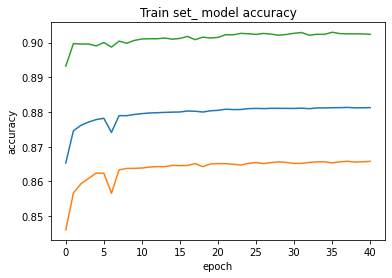

In [13]:
import matplotlib.pyplot as plt

plt.plot(history['accuracy'])
plt.plot(history['precision'])
plt.plot(history['recall'])
plt.title('Train set_ model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

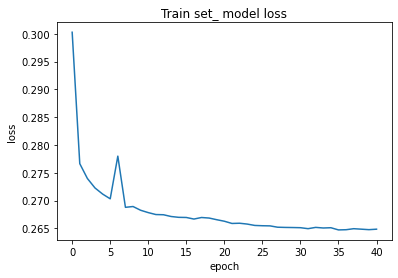

In [12]:
plt.plot(history['loss'])
plt.title('Train set_ model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

## We forgot to save the validation metrics.  
- These can be viewed in the model training progress.  
- Regardless:
    - We can see that the greatest loss minimiation occurred before the 4th epoch and the accuracy, precision and recall likewise have the greatest maximization before the 4 th epoch.    
